# Derivates valuation

Options are financial derivatives based on the value of underlying securities and they can be divided into two main type of options according to buyer's rights:

* Call options (or the right to buy)
* Put options (or the right to sell)

Thus, the holder has the right for those actions upon the underlying asset at a predefined price within a specific timeframe.

The options also have a different denomination according if they can be exercised any time before the expiration of the option (American) or at expiration date (European). We will focus on the former.

Hence, valuation of this financial derivatives is one of the first problems we might face when dealing with computational finance methods. Plenty literature can be found on how this could be solved. Idealy, we should be able to forecast the evolution of that option in order to evaluate what the potential profit could be based on the available choices (buy or sell) in the future timeframe. For this exercise we will focus on one well known method for asset valuation: the Black-Scholes-Merton (BSM) model - 1973. 

It is a pricing model for financial instruments and it is specifically used for the valuation of European options. It is based on Geometric Brownian motion and is a second order partial differential equation on its original form. The BSM model is used to determine the fair prices of stock options based on six variables: volatility, type, underlying stock price, strike price, time and risk-free rate. It is based on the principle of hedging and focuses on eliminating risks associated with the volatility of underlying assets and stock options.

In BSM the level of maturity is given by the following discretized equation (by means of Ito's lemma):

$$
S(t) = S_0 \exp{\left( (r - \frac{1}{2}\sigma^2)t + \sigma\sqrt{t} z \right)}
$$

Being $S_0$ the initial stock index level, $t$ the time to maturity, $r$ a constant representing as the riskless short rate, $\sigma$ being the the constant volatility (often computed as the standard deviation of the stock) and $z$ a normally distributed random variable. Thus, $S(t)$ can be estimated for a given stock at time $t$.

Monte Carlo methods are as well a goor optiom for simulating scenarios such as the one presented above. They can be used to analyse option values when multiple sources of uncertainty arise. The price is simulated by a set of randomly initialized values whose trajectory is averaged in order to infer most plausible trajectory.

In our specific case it comprises following steps:

* Setting $I$ random numbers for $z_i, i \in {1,...,I}$
* Computeting the $S_i(t)$ values for each randomly generated $z_i$

Let's see it with a simplistic example.

In [1]:
import numpy as np
from scipy.stats import norm

# Time
t = 1.0 # year

# Riskless short rate
r = 0.05

# Volatility (stdev)
sigma = 0.25

# Present price
S0 = 100

# Number of samples
I = 1000

# z_i values
z = np.random.standard_normal(I)

# s_t for each z_i
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * z)

Given this trajectories we could compute the expeted call/put price at time $t$ by:
* Considering the strike price $K$ as $h_i(t) = \max(S_i(t)-K, 0)$ the calling valuation would be given by the next formula: $C_0 \sim e^{-rt}\frac{1}{T}\sum_I h_i(t)$
* By switching $h_i(t) = \max(K - S_i(t), 0)$ the putting valuation would be given by the next formula: $P_0 \sim e^{-rt}\frac{1}{T}\sum_I h_i(t)$

And therefore, setup a payoff for that option.

In [2]:
K = 105 # Strike price

hT = np.maximum(ST - K, 0)
C0 = np.exp(-r * t) * sum(hT) / I
C0

10.39282138982605

In [3]:
hT = np.maximum(K - ST, 0)
P0 = np.exp(-r * t) * sum(hT) / I
P0

9.899621539587569

We could also plot the trajectories for the whole $t$ period.

In [4]:
months = 12 # in a year
dt = t/months

S = np.zeros((months+1, I))  
S[0] = S0  
for ti in range(1, months+1):
    Z = np.random.normal(size=I)
    S[ti] = S[ti-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z)

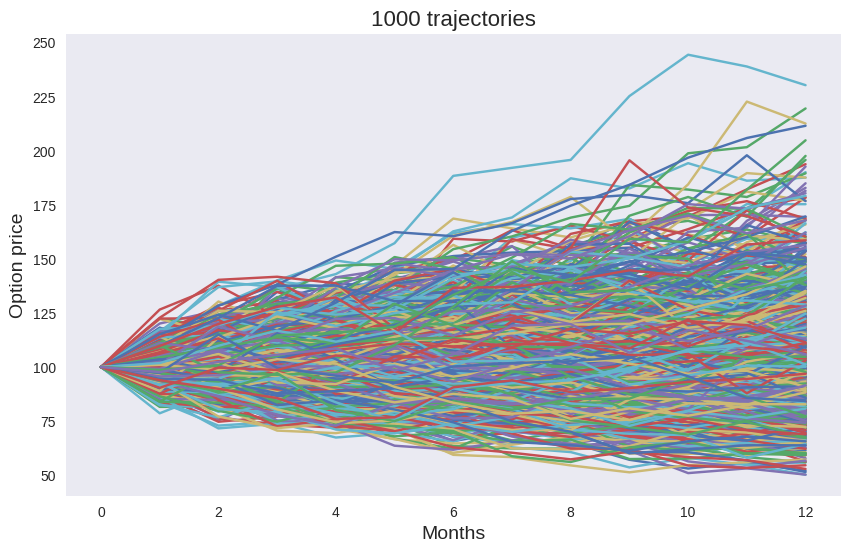

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn-v0_8')

plt.figure(figsize=(10, 6))
for si in S.T:
    plt.plot(range(len(si)), si)

plt.xlabel("Months", fontsize=14)
plt.ylabel("Option price", fontsize=14)
plt.grid()

plt.title(f"{I} trajectories", fontsize=16)
plt.show()

With that, a price distribution can be ploted at time $t$. This distribution should correspond to a _lognormal_ distribution.

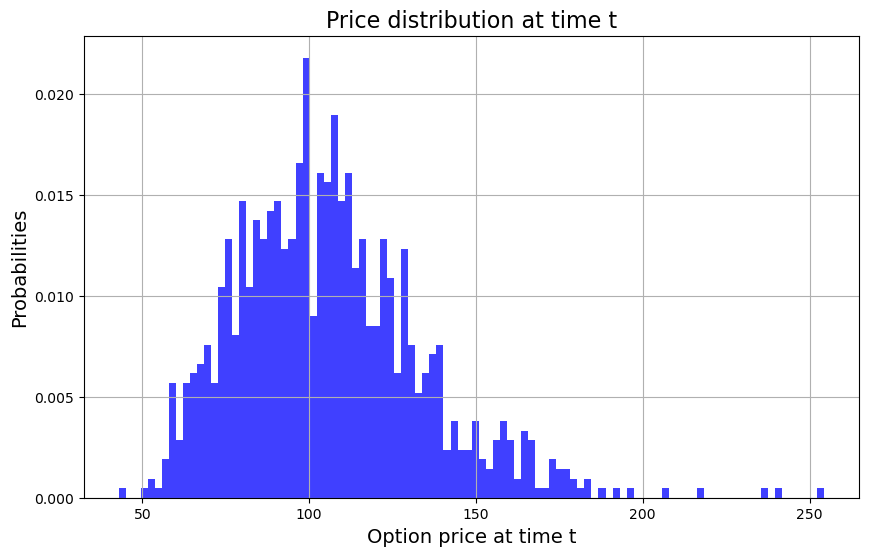

In [8]:
plt.figure(figsize=(10, 6)) 

# the histogram of the data
plt.hist(S[-1], 100, density=True, facecolor='b', alpha=0.75)

plt.xlabel("Option price at time t", fontsize=14)
plt.ylabel("Probabilities", fontsize=14)
plt.grid()

plt.title(f"Price distribution at time t", fontsize=16)
plt.show()

This is the price distribution of our option at time $t$. Let's consider now a similar exercise but with the origin in our binance data. This data corresponds to the actual value of several assets and, ideally, we would like to estimate their future evolution by these very same means.

In [9]:
import json

data = None
with open("binance-data.json", "r") as jsonfile:
    data = json.load(jsonfile)

# First example
data[0]

{'Asset': 'ETHBTC', 'Close': 0.067077, 'Stddev': 0.00754239492210189}

We will create a function for $S(t)$

In [10]:
def St(S0, sigma, t, r, num_samples = 1000):

    # z_i values
    z = np.random.standard_normal(num_samples)

    # s_t for each z_i
    return S0 * np.exp((r - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * z)

And plot the results.

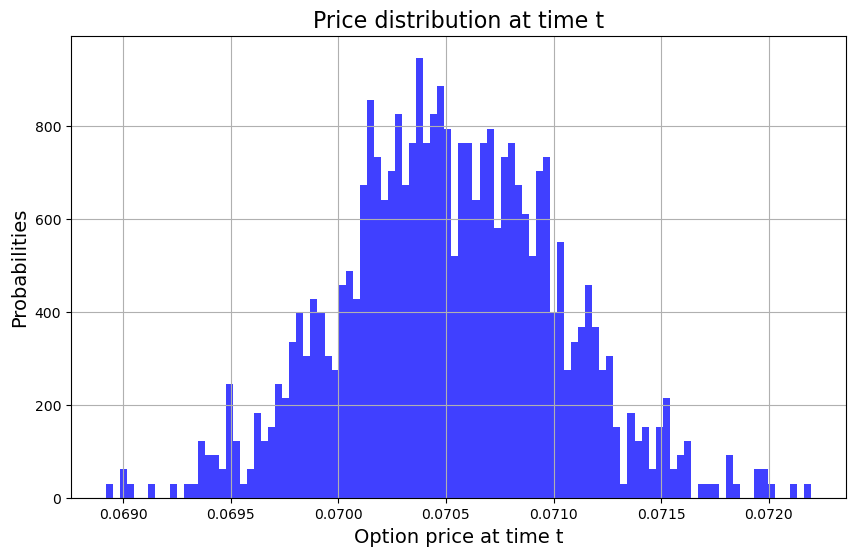

In [11]:
asset_name = data[0]["Asset"]
S0 = float(data[0]["Close"])
sigma = data[0]["Stddev"]

t = 1.0 #year
r = 0.05 # riskless short rate
ST = St(S0, sigma, t, r)

plt.figure(figsize=(10, 6)) 

# the histogram of the data
plt.hist(ST, 100, density=True, facecolor='b', alpha=0.75)

plt.xlabel("Option price at time t", fontsize=14)
plt.ylabel("Probabilities", fontsize=14)
plt.grid()

plt.title(f"Price distribution at time t", fontsize=16)
plt.show()

In [12]:
np.mean(ST)

0.0705166514532268

In [13]:
np.std(ST)

0.0005058189417368054

With that information on the future of our option, a payoff function can be set as follows.

In [14]:
def payoff_function(St, K):

    hT = np.maximum(St - K, 0)
    C0 = np.exp(-r * t) * sum(hT) / I

    return C0

Let's assume a strike price with an increase of 5%.

In [15]:
K = S0*1.05 # strike price

C0 = payoff_function(ST, K)
print(f'For asset {asset_name} with initial value of {S0}, its payoff value is {C0} at {t} years (K = {K})')

For asset ETHBTC with initial value of 0.067077, its payoff value is 0.00023359259866267035 at 1.0 years (K = 0.07043085)
